## Initialisation

In [9]:
!pip install keras

    100% |################################| 337kB 3.2MB/s eta 0:00:01
    100% |################################| 256kB 4.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = 'half.h5'
PATH_PREDICT_WITHOUT_GT = 'pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = 'pred_eighties_from_half_1_INCREDIBLE.csv'
PATH_PREDICT_WITH_GT = 'pred_eighties_from_half_1.h5'

C:\Users\berth\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## CNN

In [2]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, MaxPooling2D, ZeroPadding2D
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [3]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [4]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

def generator_feat(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True :
        X = np.zeros((batch_size, 8))
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X1_temp = np.array(f['S2'][batch_idxs, :,:,:])
            X1 = np.mean(X1_temp, axis=(1,2))
            X2 = np.std(np.array(f['S2'][batch_idxs, :,:,:]), axis=(1,2))
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            X[:, :4] = X1
            X[:, 4:] = X2
            yield X.tolist(), keras.utils.np_utils.to_categorical(np.array(Y), 23)
def generator_mean_std(h5_path, idxs):
    f = h5.File(h5_path, 'r')
    X = np.zeros(8)
    X1_temp = np.array(f['S2'][idxs, :,:,:])
    #print("X1_temp=",X1_temp)
    X1 = np.mean(X1_temp, axis=(0,1))
    #print("X1=",X1)
    X2 = np.std(X1_temp, axis=(0,1))
    #print("X2=",X2)
    y = f['TOP_LANDCOVER'][idxs, :]
    #print(Y)
    X[:4] = X1
    X[4:] = X2
    #print("X=",X)
    return X, int(y[0]) 

def generator_mean(h5_path, idxs):
    f = h5.File(h5_path, 'r')
    X = np.zeros(8)
    X1_temp = np.array(f['S2'][idxs, :,:,:])
    X0 = X1_temp[:,:,0]
    X1 = X1_temp[:,:,1]
    X2 = X1_temp[:,:,2]
    X3 = X1_temp[:,:,3]
    cA0 = pywt.dwt2(X0, 'haar')
    cA1 = pywt.dwt2(X1, 'haar')
    cA2 = pywt.dwt2(X2, 'haar')
    cA3 = pywt.dwt2(X3, 'haar')
    #print("X1_temp=",X1_temp)
    X[:4] = np.mean(X1_temp, axis=(0,1))
    X[4]=np.mean(np.mean(cA0))
    X[5]=np.mean(np.mean(cA1))
    X[6]=np.mean(np.mean(cA2))
    X[7]=np.mean(np.mean(cA3))
    #print("X1=",X1)
    y = f['TOP_LANDCOVER'][idxs, :]
    #print(Y)
    #print("X=",X)
    return X, int(y[0])

def generator_ond(h5_path, idxs):
    f = h5.File(h5_path, 'r')
    X = np.zeros(8)
    X1_temp = np.array(f['S2'][idxs, :,:,:])
    #print("X1_temp=",X1_temp)
    X0 = X1_temp[:,:,0]
    X1 = X1_temp[:,:,1]
    X2 = X1_temp[:,:,2]
    X3 = X1_temp[:,:,3]
    cA0 = pywt.dwt2(X0, 'haar')
    cA1 = pywt.dwt2(X1, 'haar')
    cA2 = pywt.dwt2(X2, 'haar')
    cA3 = pywt.dwt2(X3, 'haar')
    
    y = f['TOP_LANDCOVER'][idxs, :]

    X[0] = np.mean(np.mean(cA0))
    X[1] = np.mean(np.mean(cA1))
    X[2] = np.mean(np.mean(cA2))
    X[3] = np.mean(np.mean(cA3))
    X[4] = np.mean(np.std(cA0))
    X[5] = np.mean(np.std(cA1))
    X[6] = np.mean(np.std(cA2))
    X[7] = np.mean(np.std(cA3))
    #print("X=",X)
    return X, int(y[0]) 

def get_category(h5_path, idxs):
    f = h5.File(h5_path, 'r')
    categories = [0 for x in range(23)]
    Y = f['TOP_LANDCOVER'][sorted(idxs), :]
    for lbl in Y:
        categories[lbl] += 1
    return categories

In [5]:
print(generator_rf(PATH_DATA,5))

NameError: name 'generator_rf' is not defined

In [9]:
PATH_DATA = 'eighth.h5'
idxs = get_idxs(PATH_DATA)
idxs = np.random.permutation(idxs)
print("permutation done")
nb_example = 1000
Idx_C1 = []
Idx_C2 = []
Idx_C3 = []
Idx_C4 = []
Idx_C5 = []
Idx_C12 = []
Idx_C20 = []
n_1 = 0
n_2 = 0
n_3 = 0
n_4 = 0
n_5 = 0
n_12 = 0
n_20 = 0
for i in idxs:
    X,y = generator_rf(PATH_DATA,i)
    y = int(y)
    y_data[y] = y_data[y]+1
    if y == 1 and n_1 < nb_example:
        Idx_C1.append(i)
        n_1 = n_1+1
    if y == 2 and n_2 < nb_example:
        Idx_C2.append(i)
        n_2 = n_2+1
    if y == 3 and n_3 < nb_example:
        Idx_C3.append(i)
        n_3 = n_3+1
    if y == 4 and n_4 < nb_example:
        Idx_C4.append(i)
        n_4 = n_4+1
    if y == 5 and n_5 < nb_example:
        Idx_C5.append(i)
        n_5 = n_5+1
    if y == 12 and n_12 < nb_example:
        Idx_C12.append(i)
        n_12 = n_12+1
    if y == 20 and n_20 < nb_example:
        Idx_C20.append(i)
        n_20 = n_20+1
    n = n_1+n_2+n_3+n_4+n_5+n_12+n_20
    if n == 7*nb_example:        
        break;
    if n%500==0:
        print("n=",n)
        print(n_1,n_2,n_3,n_4,n_5,n_12,n_20)

permutation done


KeyboardInterrupt: 

In [10]:
print(n_2,n_6,n_19)

1000 0 6


In [51]:
print(len(Idx_C1),n_1)
print(len(Idx_C2),n_2)
print(len(Idx_C3),n_3)
print(len(Idx_C4),n_4)
print(len(Idx_C5),n_5)
print(len(Idx_C12),n_12)
print(len(Idx_C20),n_20)

1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
1000 1000
[252025, 233414, 1550177, 220171, 343365, 2034075, 521569, 1925616, 1769383, 1789051, 236423, 1661926, 388550, 2116073, 348852, 212022, 306600, 1884916, 246069, 1807362, 344040, 346568, 319867, 478973, 1764254, 1404775, 228223, 263753, 1026979, 308288, 1551132, 227833, 1837175, 232004, 1695980, 444503, 350227, 413564, 404795, 236373, 426234, 258941, 271573, 389432, 1628170, 248296, 260229, 1922017, 1324044, 290894, 351660, 278985, 1482923, 225846, 1326336, 1726564, 340355, 291324, 239838, 478103, 1554222, 1596548, 316319, 235684, 332616, 203314, 230560, 313483, 1547616, 1889408, 398481, 268442, 1967564, 320189, 526497, 234662, 226335, 337903, 527525, 242226, 1667880, 1845236, 1928928, 299543, 250866, 256036, 213376, 442140, 1693141, 282545, 1844181, 330750, 242396, 398896, 1688375, 1891495, 348981, 1954422, 1923065, 1363403, 210875, 1492234, 2039973, 523865, 211890, 1620744, 271058, 274361, 300912, 1326813, 1489182, 

In [3]:
import pandas as pd


In [53]:
df2 = pd.DataFrame(Idx_C1)
df2.to_csv("Idx_C1.csv")
df3 = pd.DataFrame(Idx_C2)
df3.to_csv("Idx_C2.csv")
df4 = pd.DataFrame(Idx_C3)
df4.to_csv("Idx_C3.csv")
df5 = pd.DataFrame(Idx_C4)
df5.to_csv("Idx_C4.csv")
df6 = pd.DataFrame(Idx_C5)
df6.to_csv("Idx_C5.csv")
df7 = pd.DataFrame(Idx_C12)
df7.to_csv("Idx_C12.csv")
df8 = pd.DataFrame(Idx_C20)
df8.to_csv("Idx_C20.csv")

In [15]:
PATH_DATA = 'eighth.h5'
Idx_C1 = pd.read_csv("Idx_C1.csv")
Idx_C1=Idx_C1['0'].tolist()
Idx_C2 = pd.read_csv("Idx_C2.csv")
Idx_C2=Idx_C2['0'].tolist()
Idx_C3 = pd.read_csv("Idx_C3.csv")
Idx_C3=Idx_C3['0'].tolist()
Idx_C4 = pd.read_csv("Idx_C4.csv")
Idx_C4=Idx_C4['0'].tolist()
Idx_C5 = pd.read_csv("Idx_C5.csv")
Idx_C5=Idx_C5['0'].tolist()
Idx_C12 = pd.read_csv("Idx_C12.csv")
Idx_C12=Idx_C12['0'].tolist()
Idx_C20 = pd.read_csv("Idx_C20.csv")
Idx_C20=Idx_C20['0'].tolist()



In [140]:
PATH_DATA = 'eighth.h5'
nb_example = 1000
X_train = []
y_train = []
for i in range(nb_example):
    X,y = generator_mean_std(PATH_DATA,Idx_C1[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C2[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C3[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C4[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C5[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C12[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C20[i])
    X_train.append(X)
    y_train.append(y)

In [141]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0,n_estimators=50)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [142]:
PATH_DATA = 'eighth.h5'
idxs = get_idxs(PATH_DATA)
idxs = np.random.permutation(idxs)
print("permutation done")
p_SVC = 0
p_LinearSVC = 0
p_NuSVC = 0
nb_iter = 1000
for i in range(nb_iter):
    X,y = generator_rf(PATH_DATA,idxs[i])
    y_pred = clf_SVC.predict(X.reshape(1,8))
    if y == y_pred[0]:
        p_SVC = p_SVC + 1
    y_pred = clf_NuSVC.predict(X.reshape(1,8))
    if y == y_pred[0]:
        p_NuSVC = p_NuSVC + 1
    y_pred = clf_LinearSVC.predict(X.reshape(1,8))
    if y == y_pred[0]:
        p_LinearSVC = p_LinearSVC + 1
print("accuracy SVC=",p_SVC/nb_iter)
print("accuracy Linear SVC=",p_LinearSVC/nb_iter)
print("accuracy NuSVC=",p_NuSVC/nb_iter)

permutation done
accuracy SVC= 0.215
accuracy Linear SVC= 0.2
accuracy NuSVC= 0.259


In [127]:
import pywt
PATH_DATA = 'eighth.h5'
f= h5.File(PATH_DATA, 'r')
X1_temp = np.array(f['S2'][215, :,:,:])
widths = [1]
#print("X1_temp=",X1_temp)
X1_temp = X1_temp[:,:,0]
cA =pywt.dwt2(X1_temp, 'haar')
print(cA[0])
print(cA[1])
#X1 = np.mean(X1_temp, axis=(0,1))

[[593.5     581.5     570.      591.      622.5     598.5     577.5
  618.     ]
 [614.      585.5     611.5     596.      652.      625.99994 576.
  574.5    ]
 [632.      592.99994 623.      615.5     634.5     640.      621.5
  623.     ]
 [643.5     610.5     607.      635.5     642.      633.49994 616.5
  644.5    ]
 [636.      634.99994 668.5     615.5     618.5     589.49994 564.
  601.     ]
 [624.5     610.      635.5     647.5     647.      623.5     641.
  584.     ]
 [599.      601.5     596.      603.      646.5     614.5     643.5
  589.5    ]
 [632.5     627.5     584.      579.5     637.5     609.99994 646.
  594.     ]]
(array([[ 5.00011206e-01, -1.45000038e+01,  0.00000000e+00,
        -5.99999571e+00, -1.65000057e+01,  4.99989748e-01,
        -8.49999809e+00,  1.50000048e+01],
       [ 4.99999475e+00,  1.04999895e+01, -1.44999943e+01,
        -1.08480453e-05,  1.20000019e+01, -1.00000000e+01,
        -3.00000310e+00, -1.50000167e+00],
       [-8.00000858e+00,  0.0000

In [132]:
PATH_DATA = 'eighth.h5'
nb_example = 1000
X_train = []
y_train = []
for i in range(nb_example):
    X,y = generator_mean_std(PATH_DATA,Idx_C1[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C2[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C3[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C4[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C5[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C12[i])
    X_train.append(X)
    y_train.append(y)
    X,y = generator_mean_std(PATH_DATA,Idx_C20[i])
    X_train.append(X)
    y_train.append(y)

In [133]:
from sklearn import svm
clf_NuSVC = svm.NuSVC()
clf_NuSVC.fit(X_train,y_train)
clf_SVC = svm.SVC()
clf_SVC.fit(X_train,y_train)
clf_LinearSVC = svm.LinearSVC()
clf_LinearSVC.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [136]:
PATH_DATA = 'eighth.h5'
idxs = get_idxs(PATH_DATA)
idxs = np.random.permutation(idxs)
print("permutation done")
p_SVC = 0
p_LinearSVC = 0
p_NuSVC = 0
nb_iter = 1000
for i in range(nb_iter):
    X,y = generator_mean_std(PATH_DATA,idxs[i])
    y_pred = clf_SVC.predict(X.reshape(1,8))
    if y == y_pred[0]:
        p_SVC = p_SVC + 1
    y_pred = clf_NuSVC.predict(X.reshape(1,8))
    if y == y_pred[0]:
        p_NuSVC = p_NuSVC + 1
    y_pred = clf_LinearSVC.predict(X.reshape(1,8))
    if y == y_pred[0]:
        p_LinearSVC = p_LinearSVC + 1
print("accuracy SVC=",p_SVC/nb_iter)
print("accuracy Linear SVC=",p_LinearSVC/nb_iter)
print("accuracy NuSVC=",p_NuSVC/nb_iter)

permutation done
accuracy SVC= 0.216
accuracy Linear SVC= 0.215
accuracy NuSVC= 0.242


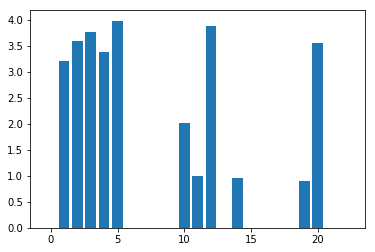

In [28]:
X = range(23)
plt.bar(X,np.log10(y_data+1))
plt.show()

In [52]:
print(df2)

           0
0     252025
1     233414
2    1550177
3     220171
4     343365
5    2034075
6     521569
7    1925616
8    1769383
9    1789051
10    236423
11   1661926
12    388550
13   2116073
14    348852
15    212022
16    306600
17   1884916
18    246069
19   1807362
20    344040
21    346568
22    319867
23    478973
24   1764254
25   1404775
26    228223
27    263753
28   1026979
29    308288
..       ...
970  1625645
971   335409
972   475528
973   399429
974   299569
975   202922
976  1730323
977  1551528
978   225199
979  2161226
980   386831
981  1555208
982  1648191
983  1650793
984   338815
985  1622308
986  1711233
987   346681
988   566093
989  2033560
990   350855
991  1693203
992   302520
993   228397
994  2122807
995  2034081
996   471290
997  1550594
998  1596739
999   223949

[1000 rows x 1 columns]


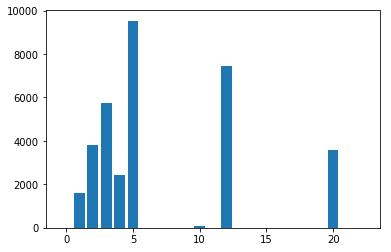

In [30]:
X = range(23)
plt.bar(X,y_data)
plt.show()

In [29]:
print(y_data)

[0.000e+00 1.622e+03 3.831e+03 5.757e+03 2.408e+03 9.534e+03 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+02 9.000e+00 7.454e+03 0.000e+00
 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 3.572e+03
 0.000e+00 0.000e+00]


In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 4, 
                            min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', 
                            bootstrap = True, oob_score = True, n_jobs = 1, random_state = None, verbose = True)  

In [59]:
rf = rf.fit(train_gen,val_gen)

TypeError: float() argument must be a string or a number, not 'generator'

In [76]:
input_shape = (16,16,4)
dropout_rate = 0.5

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=input_shape))
model.add(Conv2D(4,(3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(4, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(23, activation='softmax'))

In [78]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=10, verbose=1, validation_data=val_gen, nb_val_samples=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, validation_steps=100, epochs=10, validation_data=<generator..., steps_per_epoch=100)`
  


Epoch 1/10
100/100 [==============================] - 300s 3s/step - loss: 3.8118 - acc: 0.2375 - val_loss: 1.7062 - val_acc: 0.4550
Epoch 2/10
100/100 [==============================] - 288s 3s/step - loss: 1.8527 - acc: 0.3709 - val_loss: 1.5554 - val_acc: 0.4956
Epoch 3/10
100/100 [==============================] - 273s 3s/step - loss: 1.6868 - acc: 0.4213 - val_loss: 1.5237 - val_acc: 0.4725
Epoch 4/10
100/100 [==============================] - 271s 3s/step - loss: 1.6230 - acc: 0.4503 - val_loss: 1.4519 - val_acc: 0.4969
Epoch 5/10
100/100 [==============================] - 260s 3s/step - loss: 1.5177 - acc: 0.4841 - val_loss: 1.4648 - val_acc: 0.4891
Epoch 6/10
100/100 [==============================] - 262s 3s/step - loss: 1.4830 - acc: 0.4928 - val_loss: 1.3954 - val_acc: 0.5209
Epoch 7/10
100/100 [==============================] - 261s 3s/step - loss: 1.5250 - acc: 0.4725 - val_loss: 1.3711 - val_acc: 0.5325
Epoch 8/10
100/100 [==============================] - 264s 3s/step - 

In [79]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [80]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
7554/7554 [==============================] - 29s 4ms/step
241700


1

In [81]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [82]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

Normalized confusion matrix


<IPython.core.display.Javascript object>


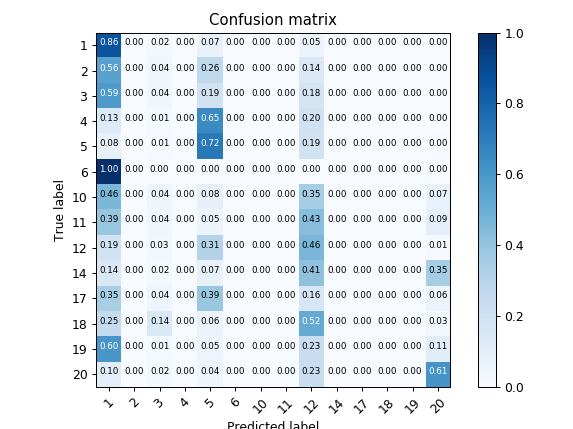

In [84]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)

In [85]:
somme = 0
for i in range (len(real_cnf_matrix)):    
    somme = somme + real_cnf_matrix[i,i] 
somme_t = sum(sum(real_cnf_matrix))
somme/somme_t

0.5226272238311956

In [86]:
model.save("incredible_florian.dqf")

In [87]:
ls


5tars-and-a-friend/      incredible_florian.dqf
Hackathon.ipynb          launch_verif_from_students_pred.py
Hackathon_Florian.ipynb  pred_eighties_from_half_1.h5
data/                    pred_eighties_from_half_1_AWESOMEGROUP.h5
eightieth.h5             pred_eighties_from_half_1_without_gt.h5
half.h5


In [ ]:
df2 = pd.DataFrame(y_pred, columns=['TOP_LANDCOVER'])
df2.to_csv(PATH_SUBMIT, index="ID")

In [ ]:
PATH_DATA = 'half.h5'
f = h5.File(h5_path, 'r')
idxs = get_idxs(PATH_DATA)
nb_example = 10000
Idx_C0 = []
Idx_C1 = []
Idx_C2 = []
Idx_C3 = []
Idx_C4 = []
Idx_C5 = []
Idx_C6 = []
Idx_C7 = []
Idx_C8 = []
Idx_C9 = []
Idx_C10 = []
Idx_C11 = []
Idx_C12 = []
Idx_C13 = []
Idx_C14 = []
Idx_C15 = []
Idx_C16 = []
Idx_C17 = []
Idx_C18 = []
Idx_C19 = []
Idx_C20 = []
Idx_C21 = []
Idx_C22 = []
n_C0 = 0
n_C1 = 0
n_C2 = 0
n_C3 = 0
n_C4 =0
n_C5 = 0
n_C6 = 0
n_C7 = 0
n_C8 = 0
n_C9 = 0
n_C10 = 0
n_C11 = 0
n_C12 = 0
n_C13 = 0
n_C14 = 0
n_C15 = 0
n_C16 = 0
n_C17 = 0
n_C18 = 0
n_C19 = 0
n_C20 = 0
n_C21 = 0
n_C22 = 0
for i in idxs:
    y = f['TOP_LANDCOVER'][i, :]
    y = int(y)
    if y == 1 and n_C1 < nb_example:
        Idx_C1.append(i)
        n_C1 = n_C1+1
    if y == 2 and n_C2 < nb_example:
        Idx_C2.append(i)
        n_C2 = n_C2+1
    if y == 3 and n_C3 < nb_example:
        Idx_C3.append(i)
        n_C3 = n_C3+1
    if y == 4 and n_C4 < nb_example:
        Idx_C4.append(i)
        n_C4 = n_C4+1
    if y == 5 and n_C5 < nb_example:
        Idx_C5.append(i)
        n_C5 = n_C5+1
    if y == 6 and n_C6 < nb_example:
        Idx_C6.append(i)
        n_C6 = n_C6+1
    if y == 7 and n_C7 < nb_example:
        Idx_C7.append(i)
        n_C7 = n_C7+1
    if y == 8 and n_C8 < nb_example:
        Idx_C8.append(i)
        n_C8 = n_C8+1
    if y == 9 and n_C9 < nb_example:
        Idx_C9.append(i)
        n_C9 = n_C9+1
    if y == 10 and n_C10 < nb_example:
        Idx_C10.append(i)
        n_C10 = n_C10+1
    if y == 11 and n_C11 < nb_example:
        Idx_C11.append(i)
        n_C11 = n_C11+1
    if y == 12 and n_12 < nb_example:
        Idx_C12.append(i)
        n_12 = n_12+1
    if y == 13 and n_13 < nb_example:
        Idx_C13.append(i)
        n_13 = n_13+1
    if y == 14 and n_14 < nb_example:
        Idx_C14.append(i)
        n_14 = n_14+1
    if y == 15 and n_15 < nb_example:
        Idx_C15.append(i)
        n_15 = n_15+1
    if y == 16 and n_16 < nb_example:
        Idx_C16.append(i)
        n_16 = n_16+1
    if y == 17 and n_17 < nb_example:
        Idx_C17.append(i)
        n_17 = n_17+1
    if y == 18 and n_18 < nb_example:
        Idx_C18.append(i)
        n_18 = n_18+1
    if y == 19 and n_19 < nb_example:
        Idx_C19.append(i)
        n_19 = n_19+1
    if y == 20 and n_20 < nb_example:
        Idx_C20.append(i)
        n_20 = n_20+1
    if y == 21 and n_21 < nb_example:
        Idx_C21.append(i)
        n_21 = n_21+1
    if y == 22 and n_22 < nb_example:
        Idx_C22.append(i)
        n_22= n_22+1

## Partie intéressante :

In [10]:
import numpy as np
Liste = []
n_liste = np.zeros(23)
for i in range(23):
    Liste.append([])
print(Liste)
print(n_liste)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


In [11]:
PATH_DATA = 'half.h5'
NEW_PATH_DATA = 'balanced.h5'
f = h5.File(h5_path, 'r')
idxs = get_idxs(PATH_DATA)
nb_example = 1000
for i in idxs:
    y = f['TOP_LANDCOVER'][i, :]
    y = int(y)
    if n_liste[y]<nb_example:
        Liste[y].append(i)
    if np.min(n_liste)==nb_example:
        break;

NameError: name 'h5' is not defined

In [ ]:
sigma = 30.0
mean = 0.0
Label = []
Liste_X = []
for i in range(23):
    perm = np.random.permutation(range(n_liste[i]))
    j = 0
    while n_liste[i]!=nb_example:
        X = f['S2'][Liste[i][perm[j]], :,:,:]
        X_temp = X
        for k in range(4):
            X_temp[:,:,k] = X[:,:,k].transpose()
        X_temp[:,:,:] = X_temp[:,:,:] + np.around(sigma*np.random.randn(16, 16, 4)+mean)
        j=j+1
        n_liste[i] += 1
        Liste[i].append(X_temp)
    Label.append(np.repeat(i,nb_example))
    Liste_X.append(Liste[i])
Label.tolist()

In [13]:
import h5py as h5
idxs = range(23*nb_example)
print (d1.shape, d2.shape)
hf = h5.File(NEW_PATH_DATA, 'w')
hf.create_dataset('ID', data=idxs)
hf.create_dataset('S2', data=Liste_X)
hf.create_dataset('TOP_LANDCOVER', data=Label)
hf.close()

ImportError: No module named h5